# Solving facilities location problem using GA- By Himanshu Bhardwaj

In developing operations strategy, facility location is of prime importance. Location of facility has impact on many things such as cost and time of delievery of goods. While establishing capacity of the factory, deciding customers to serve from a particular facility, we have to build a model that optimizes the profit or reduces the cost of operations. It has applications in disaster management also. For example, during pandemic, it was important to reduce the overall cost of vaccination. With help of the model discuss here, one can find the optimum facilities location while minimizing the overall cost of the operations. Genetic algorithm has been used as an optimizer in this case. In this case, each customer has been categoried into centroid or zones using unsupervised clustering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [2]:
#set parameters
num_customer = 10000
Max_facilities = 8
candidates_fac = 20
num_gaussian = 10
threshold =0.99

In [3]:
clusters = np.random.multinomial(num_customer, [1/num_gaussian]*num_gaussian)

In [4]:
customers = []
for i in range(num_gaussian):
    centers = (random.random()*0.1+28.5, random.random()*0.1+77)
    customers += [(random.gauss(0,0.01)+centers[0], random.gauss(0,0.01)+centers[1]) for j in range(clusters[i])]

In [5]:
cust = pd.DataFrame(customers)
cust.columns = ['Lat', 'Lon']

In [6]:
import plotly.graph_objects as G
from sklearn.cluster import MiniBatchKMeans

In [7]:
lat_center = np.mean(cust['Lat'])
long_center = np.mean(cust['Lon'])

In [9]:
num_clusters = 10

In [10]:
seed = 1000
kmeans = MiniBatchKMeans(n_clusters=num_clusters, init_size=3*num_clusters,
                         random_state=seed).fit(customers)
memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_) # Center point for each cluster
weights = list(np.histogram(memberships, bins=num_clusters)[0]) # Number of customers in each cluster
print('First cluster center:', centroids[0])
print('Weights for first 10 clusters:', weights[:10])

First cluster center: [28.59678407 77.01725118]
Weights for first 10 clusters: [867, 663, 1018, 1023, 1097, 906, 1785, 891, 948, 802]


In [11]:
centro = pd.DataFrame(centroids, columns=['Lat','Lon'])
centro['Demand'] = weights

In [12]:
fac_loc = [(random.random()*0.09+28.5, random.random()*0.08+77) for x in range(candidates_fac)]
#fac_loc = pd.read_csv('fac_loc.csv')
faclities = pd.DataFrame(fac_loc, columns=['Lat','Lon'])

In [13]:
faclities['Capacity'] = np.ones(len(faclities))*1000

In [14]:
fig = G.Figure(G.Scattermapbox(
    name='customers', 
    mode='markers', 
    lon = cust['Lon'], 
    lat= cust['Lat'],
    marker = {'size': 3},
    line = dict(width = 4.5, color = 'pink')))
fig.add_traces(G.Scattermapbox(
    name='centroids', 
    mode='markers', 
    lon = centro['Lon'], 
    lat= centro['Lat'],
    marker = {'size': 5},
    line = dict(width = 4.5, color = 'green')))
fig.add_traces(G.Scattermapbox(
    name='Candidate Facilities', 
    mode='markers', 
    lon = faclities['Lon'], 
    lat= faclities['Lat'],
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'blue')))
lat_center = np.mean(cust['Lat'])
long_center = np.mean(cust['Lon'])
fig.update_layout(mapbox_style = 'stamen-terrain', mapbox_center_lat = lat_center, mapbox_center_lon = long_center)
fig.update_layout(margin={"r":0,"l":0,"t":0,"b":0}, mapbox = {'center':{'lat':lat_center,'lon':long_center},'zoom':11})
fig.show()

In [15]:
def distance(p1,p2):
    Lo1 = p1[1]
    La1 = p1[0]
    Lo2 = p2[1]
    La2 = p2[0]
    Lo1 = math.radians(Lo1)  
    Lo2 = math.radians(Lo2)  
    La1 = math.radians(La1)  
    La2 = math.radians(La2)         
    # Using the "Haversine formula"  
    D_Lo = Lo2 - Lo1  
    D_La = La2 - La1  
    P = math.sin(D_La / 2)**2 + math.cos(La1) * math.cos(La2) * math.sin(D_Lo / 2)**2     
    Q = 2 * math.asin(math.sqrt(P))    
    # The radius of earth in kilometres.  
    R_km = 6371      
    # Then, we will calculate the result  
    return(Q * R_km)

In [16]:
def dist_mat(centroids, facilities):
    dmat = []
    for i in range(len(centroids)):
        for j in range(len(facilities)):
            dmat.append(['centroid:'+str(i), 'facility:'+str(j), distance(centroids[i], facilities[j])])
    dfm = pd.DataFrame(dmat, columns=['Centroid','facility','distance'])
    return dfm

In [17]:
distf = dist_mat(centroids, fac_loc)

In [22]:
pop_size =100
cross_rate = 0.9
mut_rate = 1/50
iterations = 500

# Optimization using Genetic Alogrithm

In [28]:
import hemi_GA6 as hga

In [29]:
error = []
best, best_value = hga.GA_function(hga.fitness, iterations, pop_size, cross_rate,
                                   mut_rate, centroids, distf, error,Max_facilities)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.08it/s]


# Cost function

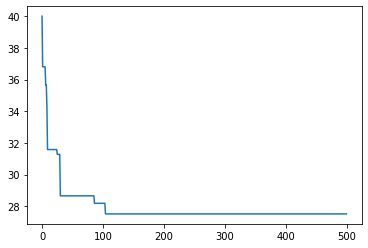

In [30]:
plt.plot(error)

In [31]:
faclities['assign'] = np.array(best[1])

In [32]:
selected_fac = faclities[faclities['assign']==1]
selected_fac

Lat        Lon  Capacity  assign
1   28.589627  77.048463    1000.0       1
8   28.532529  77.028528    1000.0       1
11  28.581767  77.020696    1000.0       1
13  28.549275  77.008006    1000.0       1
14  28.535773  77.026644    1000.0       1
17  28.556095  77.006106    1000.0       1
18  28.573435  77.057163    1000.0       1
19  28.549114  77.075961    1000.0       1

In [33]:
vv = best[0]

In [34]:
aaa=np.where(np.array(vv[9])==1)

In [35]:
arr = np.array([11,12,13,14])

In [36]:
selected_fac.iloc[7,0]

28.549113757276082

In [38]:
qq = [selected_fac.iloc[[np.where(np.array(vv[i])==1)[0][0]]] for i in range(len(centro))]

In [39]:
aa = []
bb = []
for i in range(len(centro)):
    xx = np.where(np.array(vv[i])==1)[0][0]
    print(xx)
    aa.append(selected_fac.iloc[xx,0])
    bb.append(selected_fac.iloc[xx,1])

2
7
1
1
0
7
7
2
3
7


In [40]:
centro['fac_lat'] = np.array(aa)
centro['fac_lon'] = np.array(bb)

In [41]:
centro.to_csv('result.csv')

**Selected facilities has been shown in below plot (with red dot) along with the assigned centroid of customers with connected lines**

In [42]:
fig = G.Figure(G.Scattermapbox(
    name='customers', 
    mode='markers', 
    lon = cust['Lon'], 
    lat= cust['Lat'],
    marker = {'size': 3},
    line = dict(width = 4.5, color = 'pink')))
fig.add_traces(G.Scattermapbox(
    name='centroids', 
    mode='markers', 
    lon = centro['Lon'], 
    lat= centro['Lat'],
    marker = {'size': 5},
    line = dict(width = 4.5, color = 'green')))
fig.add_traces(G.Scattermapbox(
    name='Candidate Facilities', 
    mode='markers', 
    lon = faclities['Lon'], 
    lat= faclities['Lat'],
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'blue')))
fig.add_traces(G.Scattermapbox(
    name='Selected Facilities', 
    mode='markers', 
    lon = centro['fac_lon'], 
    lat= centro['fac_lat'],
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'red')))
for i in range(len(centro)):
    fig.add_traces(G.Scattermapbox(
        name='assigned Facilities', 
        mode='lines', 
        lon = [centro.iloc[i,1], centro.iloc[i,4]],
        lat= [centro.iloc[i,0], centro.iloc[i,3]],
        line = dict(width = 1, color = 'black')))
lat_center = np.mean(cust['Lat'])
long_center = np.mean(cust['Lon'])
fig.update_layout(mapbox_style = 'stamen-terrain', mapbox_center_lat = lat_center, mapbox_center_lon = long_center)
fig.update_layout(margin={"r":0,"l":0,"t":0,"b":0}, mapbox = {'center':{'lat':lat_center,'lon':long_center},'zoom':11})
fig.show()